In [1]:
# imports

# standard import of pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Floats (decimal numbers) should be displayed rounded with 2 decimal places
pd.options.display.float_format = "{:,.2f}".format
# Set style for plots
plt.style.use('fivethirtyeight') 

In [3]:
# getting dataframes

%store -r final_merge


### Order Lead Time = Days needed from order date & order arival scan date

In [4]:
final_merge.sample(5)

,order_id,order_date,state,region,ship_mode,ready_to_ship_date,pickup_date,arrival_scan_date
2775,US-2018-122910,2018-05-12,Colorado,West,Standard Processing,NaT,NaT,NaT
383,CA-2018-160171,2018-10-19,California,West,Standard Processing,NaT,NaT,NaT
760,CA-2018-114468,2018-08-23,Illinois,Central,Express,NaT,NaT,NaT
4306,CA-2020-108287,2020-12-18,North Carolina,South,Express,NaT,2020-12-21,NaT
4927,CA-2017-154893,2017-12-21,California,West,Standard Processing,NaT,NaT,NaT


In [5]:
# Create new data frame
lead_time = final_merge.copy()

## keep only necessary columns
# new_df = old_df.filter(items=['col1', 'col2']).copy()
lead_time = lead_time.filter(items=["order_date", "ship_mode", "arrival_scan_date"]).copy()

In [6]:
lead_time.columns

Index(['order_date', 'ship_mode', 'arrival_scan_date'], dtype='object')

In [7]:
lead_time.head(1)

,order_date,ship_mode,arrival_scan_date
0,2019-01-16,Standard Processing,NaT


In [8]:
# show me no. of cells that are NOT NULL
lead_time['arrival_scan_date'].notnull().sum()

333

In [9]:
# show me no. of cells that ARE NULL
lead_time['arrival_scan_date'].isnull().sum()

4677

In [10]:
# Drop rows if there are null values in column arrival scan date
lead_time.dropna(subset=['arrival_scan_date'], inplace=True)

In [11]:
# should only have 333 rows of date confirmed below after dropping
lead_time['arrival_scan_date'].info()

<class 'pandas.core.series.Series'>
Index: 333 entries, 17 to 5005
Series name: arrival_scan_date
Non-Null Count  Dtype         
--------------  -----         
333 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 5.2 KB


In [12]:
# Create new column to display the calculated lead time
lead_time["order_lead_time"] = lead_time["arrival_scan_date"] - lead_time["order_date"]

In [13]:
# Display new column Order Lead Time and results 
lead_time["order_lead_time"]

17     12 days
24     13 days
40     11 days
59     13 days
80     10 days
         ...  
4978   14 days
4981   11 days
4984   14 days
4987    7 days
5005   11 days
Name: order_lead_time, Length: 333, dtype: timedelta64[ns]

In [14]:
# Create new column for Days in INT format in case we need this for calculating
lead_time["order_lead_time_i"] = lead_time["order_lead_time"].dt.days
lead_time.head(2)

,order_date,ship_mode,arrival_scan_date,order_lead_time,order_lead_time_i
17,2019-09-11,Standard Processing,2019-09-23,12 days,12
24,2019-04-23,Standard Processing,2019-05-06,13 days,13


In [15]:
## Want to calculate what day of week the order was made on, and arrived on - to see later if there are correlations

# Day of order
lead_time["ordered_day"] = lead_time["order_date"].dt.day_name()

# Day of arrival
lead_time["arrival_day"] = lead_time["arrival_scan_date"].dt.day_name()
lead_time.tail(3)

,order_date,ship_mode,arrival_scan_date,order_lead_time,order_lead_time_i,ordered_day,arrival_day
4984,2019-11-25,Standard Processing,2019-12-09,14 days,14,Monday,Monday
4987,2019-09-16,Express,2019-09-23,7 days,7,Monday,Monday
5005,2019-10-31,Standard Processing,2019-11-11,11 days,11,Thursday,Monday


In [16]:
%store lead_time

Stored 'lead_time' (DataFrame)


### What days do customers receive their orders?

In [17]:
# What days do the customers receive their orders?
lead_time.arrival_day.unique()

## Customers have never received their delivery on a Saturday or Sunday

array(['Monday', 'Friday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype=object)

### KPI: Order Lead Time observed

In [18]:
# Mean value = 10.83 days
lead_time.order_lead_time_i.mean()

10.834834834834835

In [19]:
# Describe the data
lead_time.order_lead_time_i.describe()

count   333.00
mean     10.83
std       2.86
min       3.00
25%       9.00
50%      11.00
75%      13.00
max      17.00
Name: order_lead_time_i, dtype: float64

''

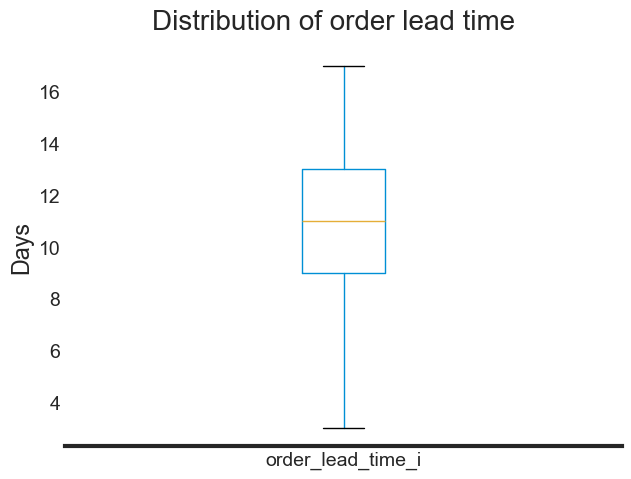

In [28]:
plt.suptitle('Distribution of order lead time', fontsize=20)
plt.subplots_adjust(hspace = .5, wspace = .2, top = .9) # adjusts the space between the single subplots
lead_time.boxplot(column='order_lead_time_i') # creates boxplot for order lead time
plt.ylabel('Days')
sns.set_style("white")
sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)
sns.set_style({'axes.facecolor':'white', 'grid.color': 'white'})


;

### What is the average order lead time based on shipping mode selected?

In [21]:
lead_time.head(1)

,order_date,ship_mode,arrival_scan_date,order_lead_time,order_lead_time_i,ordered_day,arrival_day
17,2019-09-11,Standard Processing,2019-09-23,12 days,12,Wednesday,Monday


In [22]:
# create new DF sorted by ship mode and using unique values from the order_date column
# then display a column with the COUNT for order_counter and MEAN value for avg_order_lead_time
order_lead_with_ship_mode = lead_time.groupby('ship_mode').agg(order_count=('order_date',lambda x: x.nunique()),
                                    avg_order_lead_time=('order_lead_time_i','mean'))

order_lead_with_ship_mode

# The lambda function lambda x: x in Python is an anonymous function that returns its input x unchanged. 
# In other words, it's an identity function.
# When you pass lambda x: x to one of these functions, it effectively means "do nothing" because it returns the input unchanged. 
# This can be useful in cases where you need to pass a function as an argument to another function but don't want to alter the data.

,order_count,avg_order_lead_time
ship_mode,,
Express,62,7.05
Standard Processing,146,11.93
